In [1]:
!pip install transformers bitsandbytes datasets umap-learn matplotlib

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.manifold import TSNE
import umap
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.metrics import silhouette_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires 

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the quantized model
MODEL_NAME = "bigscience/bloom-7b1"  # Replace with GEMMA model name as needed
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    load_in_8bit=True,
    trust_remote_code=True,
)
print(f"Model loaded successfully with quantization on {device}.")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/739 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/28.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.16G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model loaded successfully with quantization on cuda.


In [3]:
# Load FLORES200 dataset
dataset = load_dataset("facebook/flores", "all", split="dev")  # Use the development set

# Select languages to process
languages =["kaz_Cyrl","mkd_Cyrl","srp_Cyrl", "rus_Cyrl","ukr_Cyrl", "hin_Deva", "npi_Deva","mar_Deva","bho_Deva","ben_Beng"]
# Extract parallel sentences
parallel_sentences = {}
for lang in languages:
    parallel_sentences[lang] = dataset[f"sentence_{lang}"][:100]  # First 100 sentences

# Function to extract sentence representations with batch processing
def get_representations_quantized(model, tokenizer, sentences, layer_indices, batch_size=5):
    """
    Extract embeddings layer-wise for a batch of sentences.
    Args:
        model: HuggingFace model object.
        tokenizer: HuggingFace tokenizer object.
        sentences: List of sentences to process.
        layer_indices: List of layer indices to extract embeddings from.
        batch_size: Number of sentences to process in one batch.
    Returns:
        A dictionary where keys are layer indices and values are 2D arrays (sentences × embedding_dim).
    """
    # Initialize storage for each layer
    layer_representations = {layer: [] for layer in layer_indices}

    for i in range(0, len(sentences), batch_size):
        batch = sentences[i : i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            hidden_states = outputs.hidden_states  # List of tensors (one per layer)

        # Extract mean-pooled embeddings for each layer
        for layer in layer_indices:
            layer_embedding = hidden_states[layer].mean(dim=1)  # Mean-pooling over tokens
            layer_representations[layer].append(layer_embedding.cpu().numpy())

    # Concatenate batches for each layer
    for layer in layer_indices:
        layer_representations[layer] = np.vstack(layer_representations[layer])

    return layer_representations


README.md:   0%|          | 0.00/11.8k [00:00<?, ?B/s]

flores.py:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

The repository for facebook/flores contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/facebook/flores.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating dev split: 0 examples [00:00, ? examples/s]

Generating devtest split: 0 examples [00:00, ? examples/s]

In [4]:
# Layers to analyze
layers_to_analyze = [0, 7, 15, 23, 29]
# Extract representations for all languages
all_representations = {}
for lang in languages:
    print(f"Processing language: {lang}")
    all_representations[lang] = get_representations_quantized(
        model, tokenizer, parallel_sentences[lang], layers_to_analyze, batch_size=5
    )


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Processing language: kaz_Cyrl
Processing language: mkd_Cyrl
Processing language: srp_Cyrl
Processing language: rus_Cyrl
Processing language: ukr_Cyrl
Processing language: hin_Deva
Processing language: npi_Deva
Processing language: mar_Deva
Processing language: bho_Deva
Processing language: ben_Beng


In [5]:
# Function to visualize embeddings
def visualize_multilingual_embeddings(representations, languages, method="TSNE", title="Embedding Visualization"):
    """
    Visualize embeddings for multiple languages.
    Args:
        representations: Dictionary of language embeddings.
        languages: List of languages.
        method: Dimensionality reduction method ('TSNE' or 'UMAP').
        title: Title of the plot.
    """
    combined_repr = []
    labels = []
    for lang in languages:
        combined_repr.append(representations[lang])
        labels.extend([lang] * len(representations[lang]))
    combined_repr = np.vstack(combined_repr)

    # Perform dimensionality reduction
    if method == "TSNE":
        perplexity = min(30, len(combined_repr) - 1)
        reducer = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    elif method == "UMAP":
        reducer = umap.UMAP(n_components=2, random_state=42)
    else:
        raise ValueError("Invalid method. Use 'TSNE' or 'UMAP'.")

    reduced = reducer.fit_transform(combined_repr)

    # Plot
    plt.figure(figsize=(10, 8))
    for lang in languages:
        indices = [i for i, label in enumerate(labels) if label == lang]
        plt.scatter(reduced[indices, 0], reduced[indices, 1], label=lang, alpha=0.7)

    plt.title(title)
    plt.legend()
    plt.show()

Visualizing embeddings for Layer 0


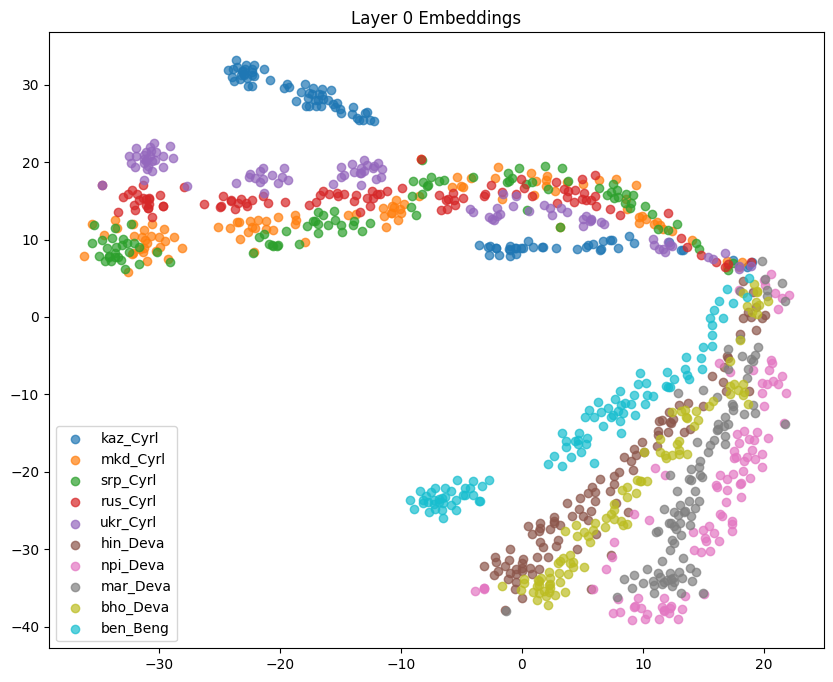

Visualizing embeddings for Layer 7


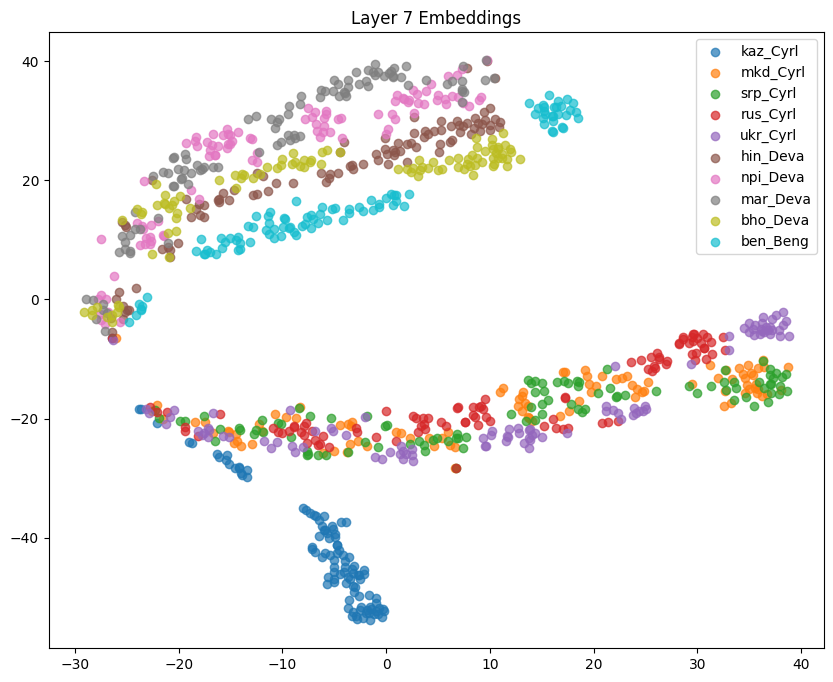

Visualizing embeddings for Layer 15


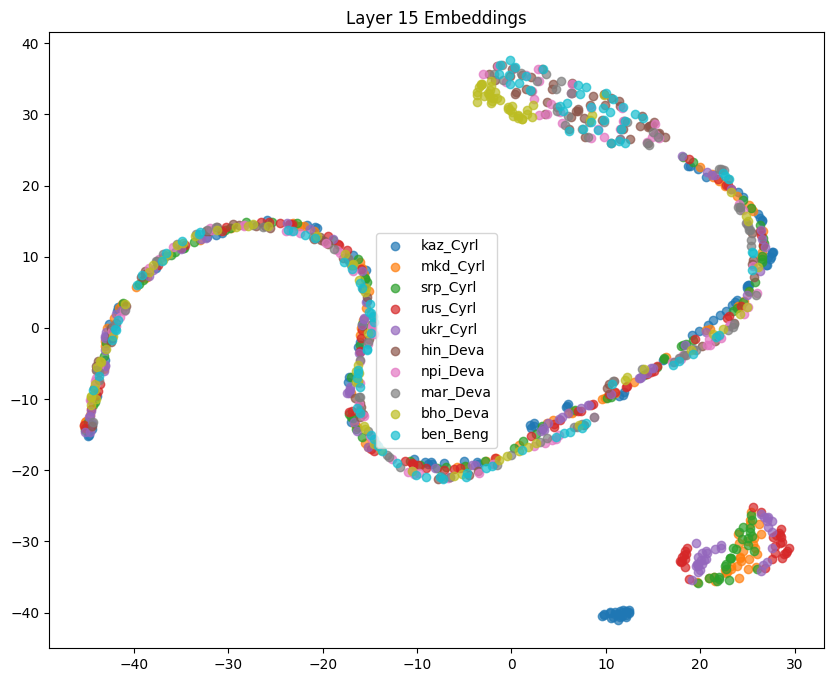

Visualizing embeddings for Layer 23


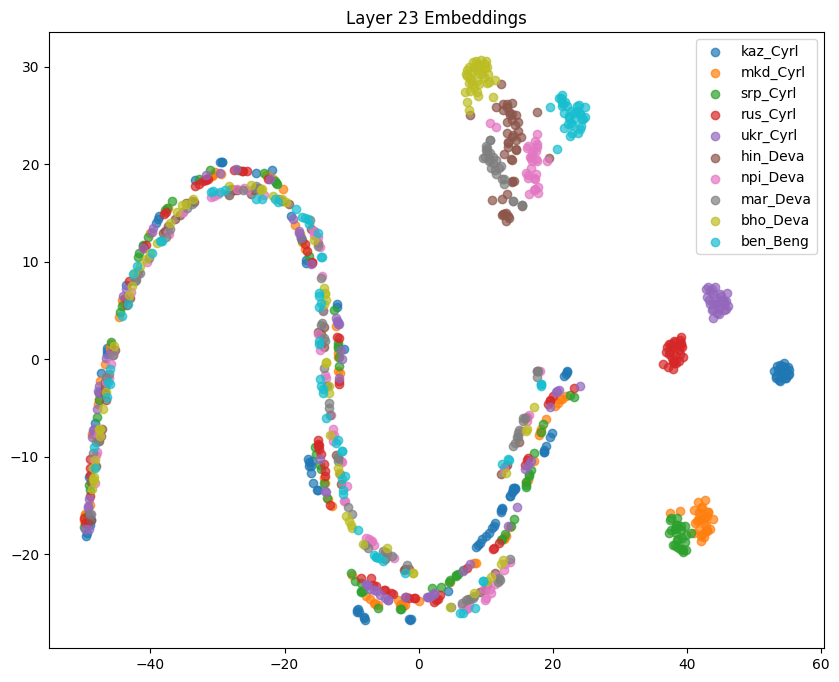

Visualizing embeddings for Layer 29


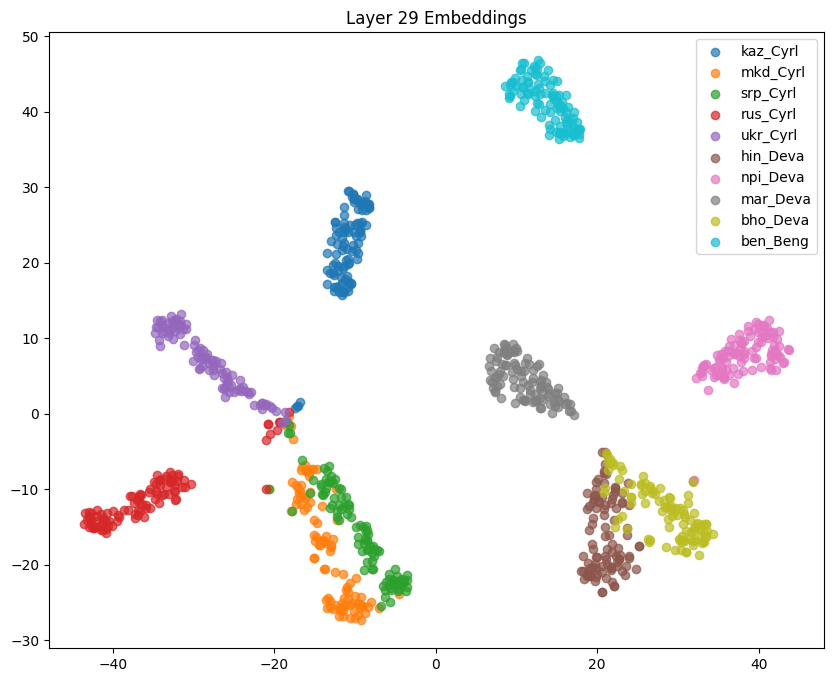

In [6]:
# Visualize embeddings for each layer
# Visualize embeddings for each layer
for layer in layers_to_analyze:
    print(f"Visualizing embeddings for Layer {layer}")
    # Gather embeddings for this layer across all languages
    layer_representations = {lang: all_representations[lang][layer] for lang in languages}
    visualize_multilingual_embeddings(layer_representations, languages, method="TSNE", title=f"Layer {layer} Embeddings")



In [7]:

from sklearn.metrics import silhouette_score

def calculate_silhouette_scores(layer_representations, languages):
    """
    Calculate the silhouette score for embeddings of a specific layer.
    Args:
        layer_representations: Dictionary with embeddings for each language.
        languages: List of languages.
    Returns:
        Silhouette Score (float).
    """
    combined_repr = []
    labels = []
    for lang in languages:
        combined_repr.append(layer_representations[lang])
        labels.extend([lang] * len(layer_representations[lang]))
    combined_repr = np.vstack(combined_repr)
    return silhouette_score(combined_repr, labels)


In [ ]:
# Evaluate Silhouette Scores for each layer
for layer in layers_to_analyze:
    print(f"Calculating Silhouette Score for Layer {layer}")
    # Gather embeddings for this layer across all languages
    layer_representations = {lang: all_representations[lang][layer] for lang in languages}

    # Calculate silhouette score
    score = calculate_silhouette_scores(layer_representations, languages)
    print(f"Silhouette Score for Layer {layer}: {score:.4f}")


Calculating Silhouette Score for Layer 0
Silhouette Score for Layer 0: -0.0030
Calculating Silhouette Score for Layer 7
Silhouette Score for Layer 7: 0.0449
Calculating Silhouette Score for Layer 15
Silhouette Score for Layer 15: -0.0867
Calculating Silhouette Score for Layer 23
Silhouette Score for Layer 23: -0.0776
Calculating Silhouette Score for Layer 29
Silhouette Score for Layer 29: 0.3175


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Model loaded successfully on cuda.
Processing language: kaz_Cyrl
Processing language: mkd_Cyrl
Processing language: srp_Cyrl
Processing language: rus_Cyrl
Processing language: ukr_Cyrl
Processing language: hin_Deva
Processing language: npi_Deva
Processing language: mar_Deva
Processing language: bho_Deva
Processing language: ben_Beng
Visualizing embeddings for Layer 0


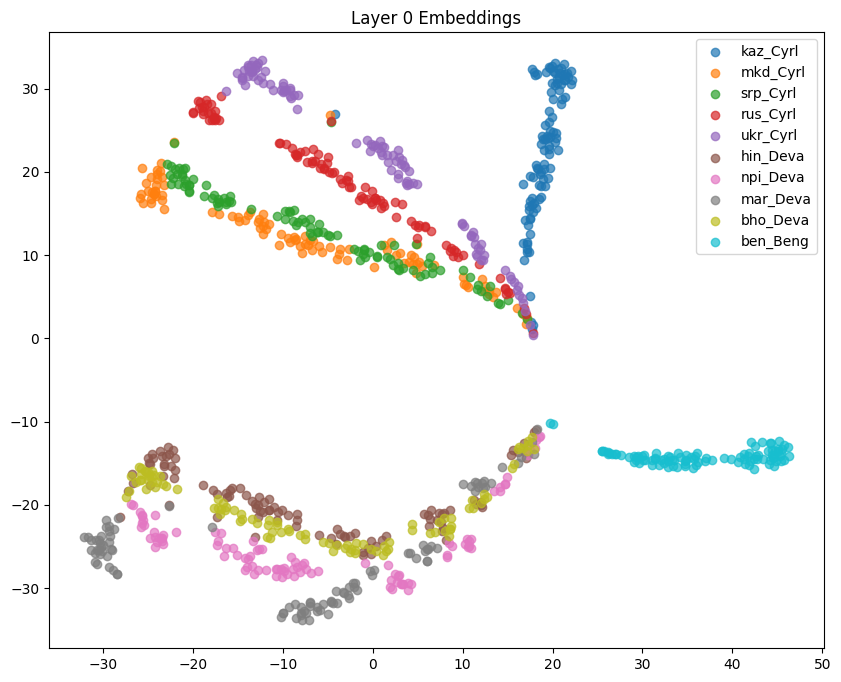

Visualizing embeddings for Layer 7


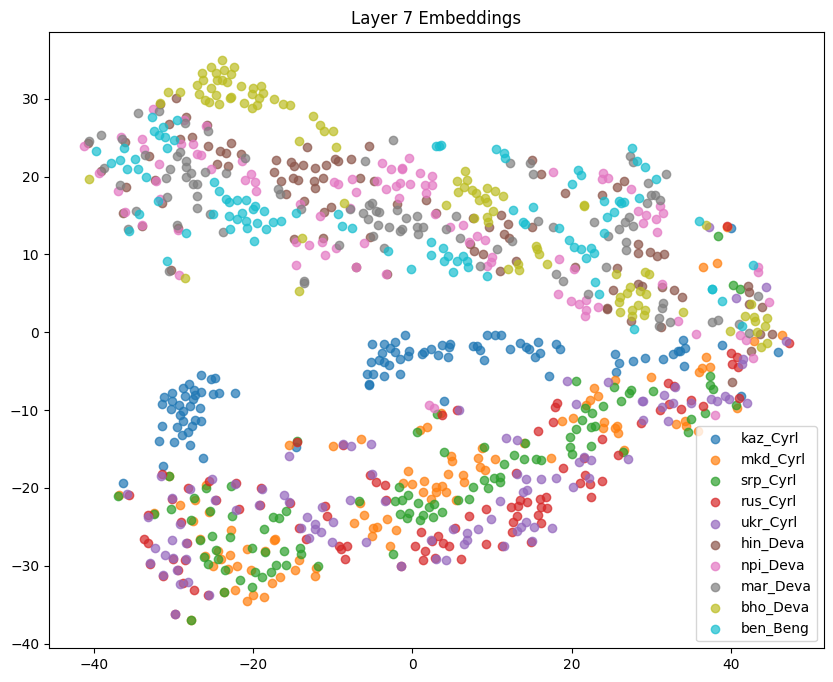

Visualizing embeddings for Layer 15


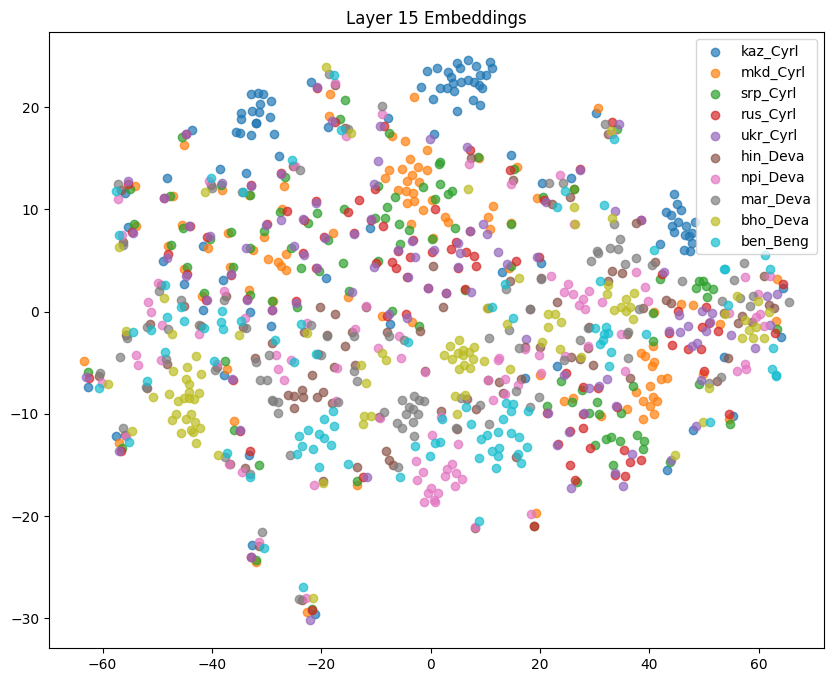

Visualizing embeddings for Layer 23


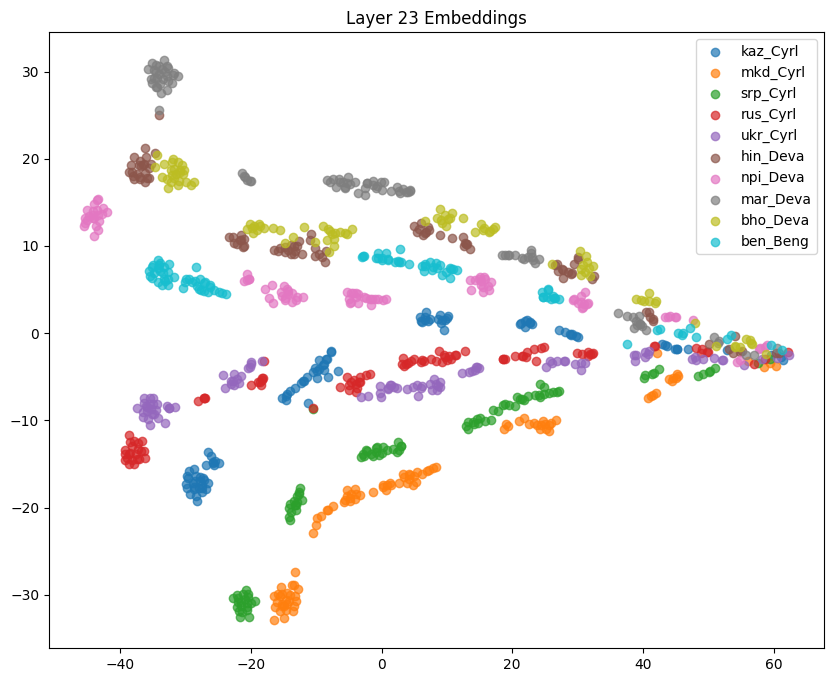

In [8]:
!pip install transformers datasets umap-learn matplotlib

import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.manifold import TSNE
import umap
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.metrics import silhouette_score

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the XLM-R model
MODEL_NAME = "xlm-roberta-large"  # Replace with other XLM-R model variants if needed
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to(device)
print(f"Model loaded successfully on {device}.")

# Load FLORES200 dataset
dataset = load_dataset("facebook/flores", "all", split="dev")

# Select languages to process
languages = ["kaz_Cyrl","mkd_Cyrl","srp_Cyrl", "rus_Cyrl","ukr_Cyrl", "hin_Deva", "npi_Deva","mar_Deva","bho_Deva","ben_Beng"]
# Extract parallel sentences
parallel_sentences = {}
for lang in languages:
    parallel_sentences[lang] = dataset[f"sentence_{lang}"][:100]  # First 100 sentences

# Function to extract sentence representations with batch processing
def get_representations(model, tokenizer, sentences, layer_indices, batch_size=5):
    """
    Extract embeddings layer-wise for a batch of sentences.
    Args:
        model: HuggingFace model object.
        tokenizer: HuggingFace tokenizer object.
        sentences: List of sentences to process.
        layer_indices: List of layer indices to extract embeddings from.
        batch_size: Number of sentences to process in one batch.
    Returns:
        A dictionary where keys are layer indices and values are 2D arrays (sentences × embedding_dim).
    """
    # Initialize storage for each layer
    layer_representations = {layer: [] for layer in layer_indices}

    for i in range(0, len(sentences), batch_size):
        batch = sentences[i : i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            hidden_states = outputs.hidden_states  # List of tensors (one per layer)

        # Extract mean-pooled embeddings for each layer
        for layer in layer_indices:
            layer_embedding = hidden_states[layer].mean(dim=1)  # Mean-pooling over tokens
            layer_representations[layer].append(layer_embedding.cpu().numpy())

    # Concatenate batches for each layer
    for layer in layer_indices:
        layer_representations[layer] = np.vstack(layer_representations[layer])

    return layer_representations

# Layers to analyze
layers_to_analyze = [0, 7, 15, 23]
# Extract representations for all languages
all_representations = {}
for lang in languages:
    print(f"Processing language: {lang}")
    all_representations[lang] = get_representations(
        model, tokenizer, parallel_sentences[lang], layers_to_analyze, batch_size=5
    )

# Function to visualize embeddings
def visualize_multilingual_embeddings(representations, languages, method="TSNE", title="Embedding Visualization"):
    """
    Visualize embeddings for multiple languages.
    Args:
        representations: Dictionary of language embeddings.
        languages: List of languages.
        method: Dimensionality reduction method ('TSNE' or 'UMAP').
        title: Title of the plot.
    """
    combined_repr = []
    labels = []
    for lang in languages:
        combined_repr.append(representations[lang])
        labels.extend([lang] * len(representations[lang]))
    combined_repr = np.vstack(combined_repr)

    # Perform dimensionality reduction
    if method == "TSNE":
        perplexity = min(30, len(combined_repr) - 1)
        reducer = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    elif method == "UMAP":
        reducer = umap.UMAP(n_components=2, random_state=42)
    else:
        raise ValueError("Invalid method. Use 'TSNE' or 'UMAP'.")

    reduced = reducer.fit_transform(combined_repr)

    # Plot
    plt.figure(figsize=(10, 8))
    for lang in languages:
        indices = [i for i, label in enumerate(labels) if label == lang]
        plt.scatter(reduced[indices, 0], reduced[indices, 1], label=lang, alpha=0.7)

    plt.title(title)
    plt.legend()
    plt.show()

# Visualize embeddings for each layer
for layer in layers_to_analyze:
    print(f"Visualizing embeddings for Layer {layer}")
    # Gather embeddings for this layer across all languages
    layer_representations = {lang: all_representations[lang][layer] for lang in languages}
    visualize_multilingual_embeddings(layer_representations, languages, method="TSNE", title=f"Layer {layer} Embeddings")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Model loaded successfully on cuda.
The M-BERT model has 12 layers.
Processing language: kaz_Cyrl
Processing language: mkd_Cyrl
Processing language: srp_Cyrl
Processing language: rus_Cyrl
Processing language: ukr_Cyrl
Processing language: hin_Deva
Processing language: npi_Deva
Processing language: mar_Deva
Processing language: bho_Deva
Processing language: ben_Beng
Visualizing embeddings for Layer 0


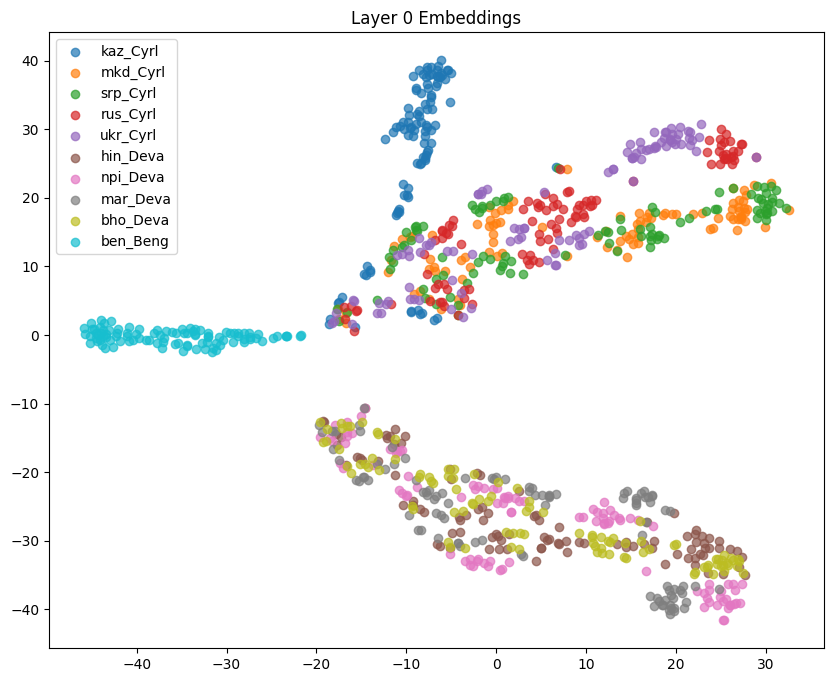

Visualizing embeddings for Layer 1


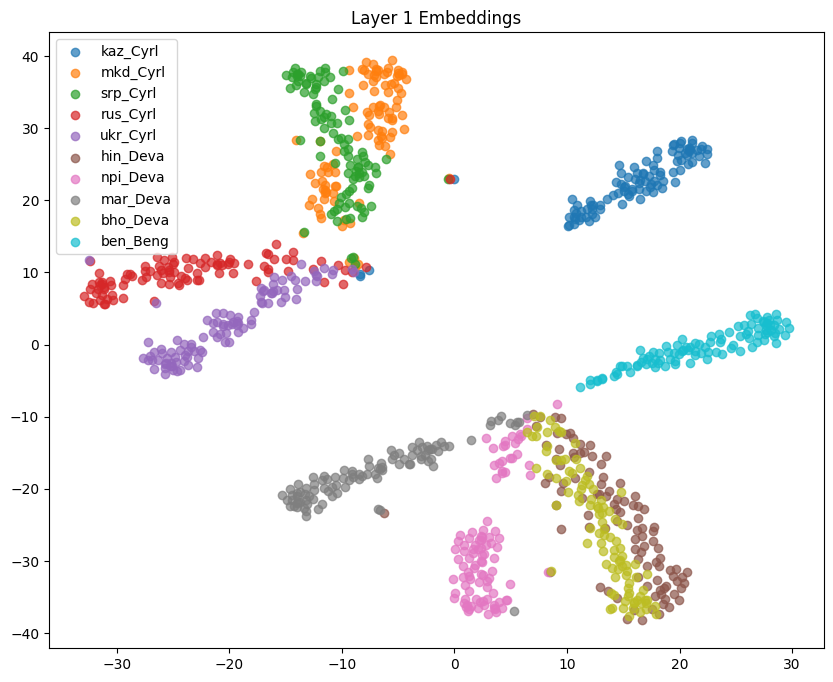

Visualizing embeddings for Layer 2


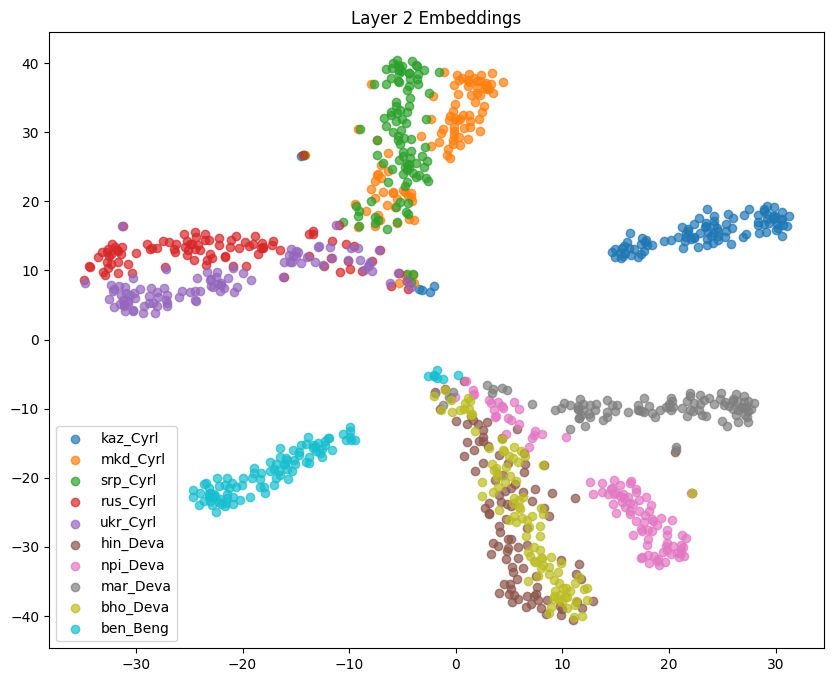

Visualizing embeddings for Layer 3


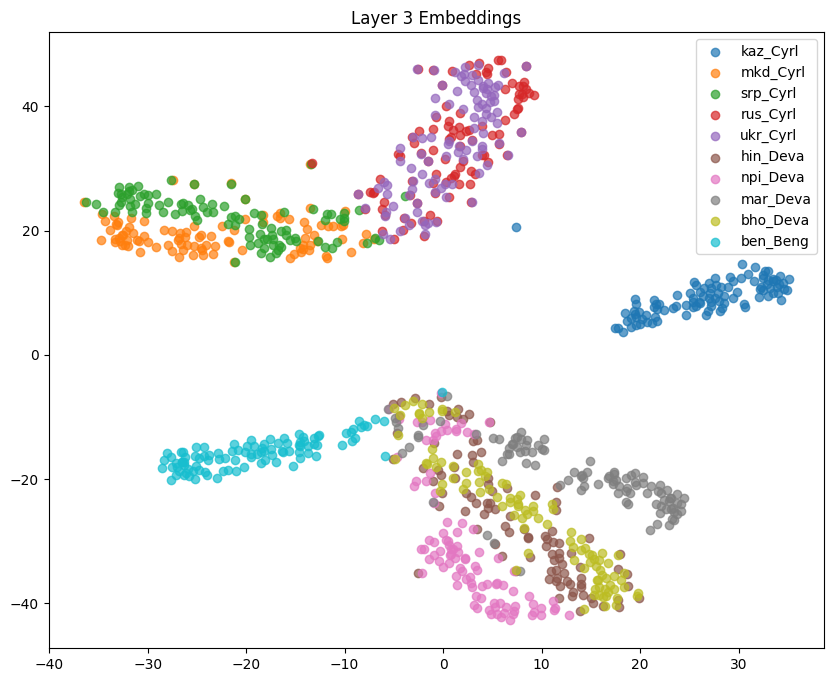

Visualizing embeddings for Layer 4


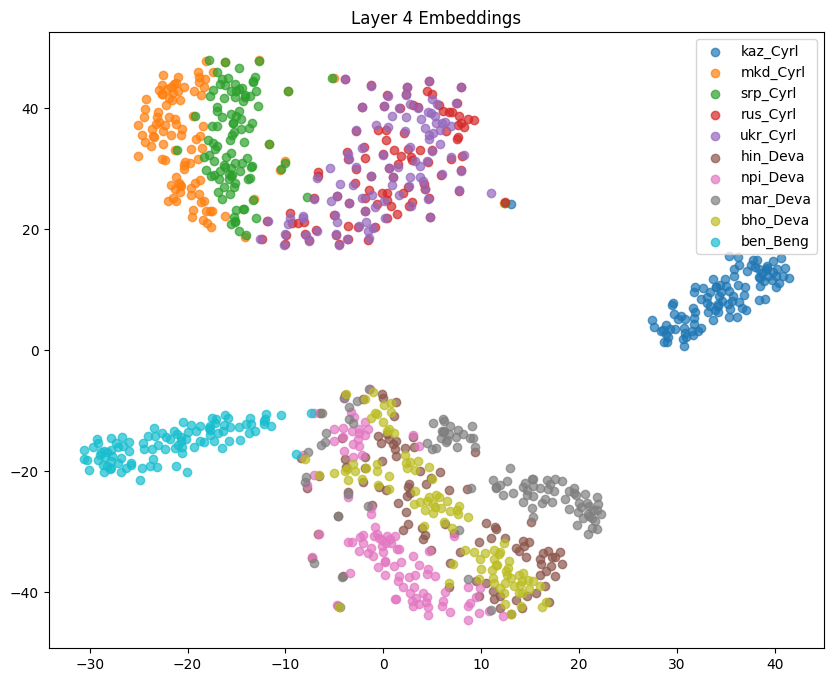

Visualizing embeddings for Layer 5


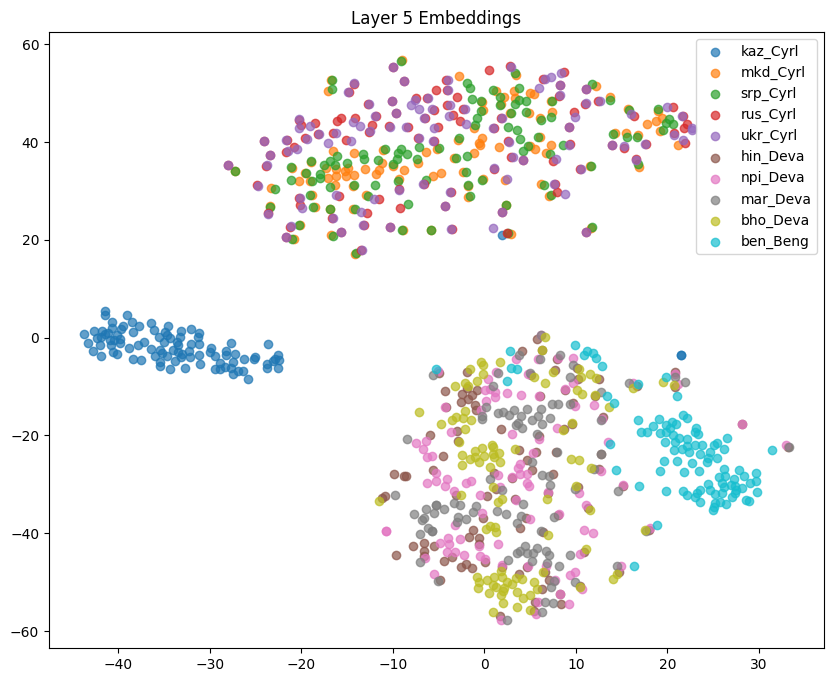

Visualizing embeddings for Layer 6


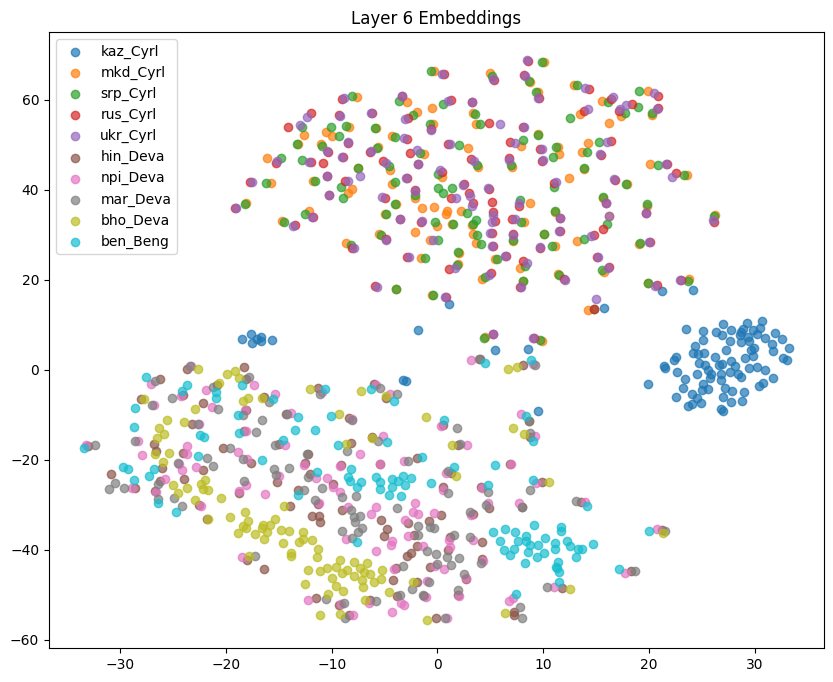

Visualizing embeddings for Layer 7


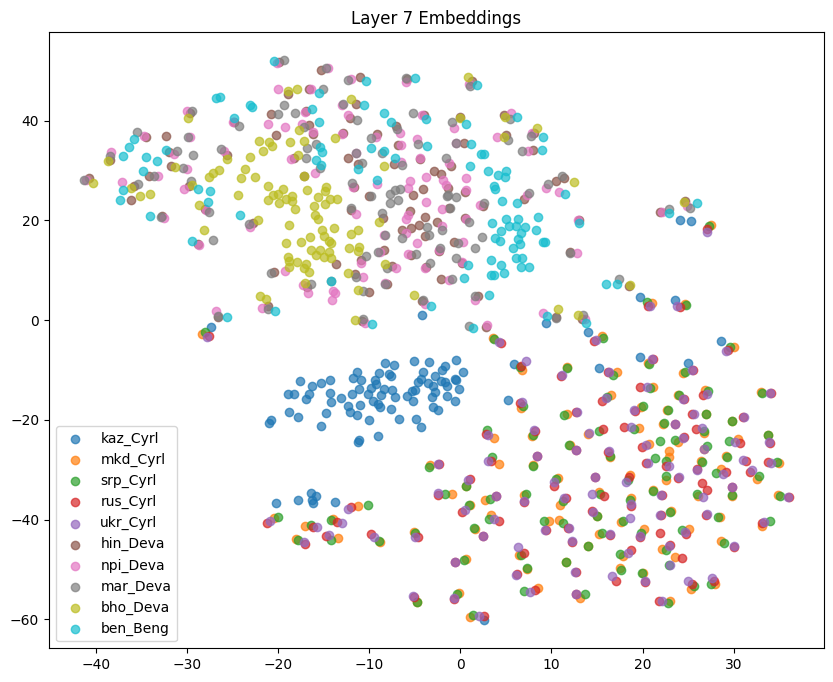

Visualizing embeddings for Layer 8


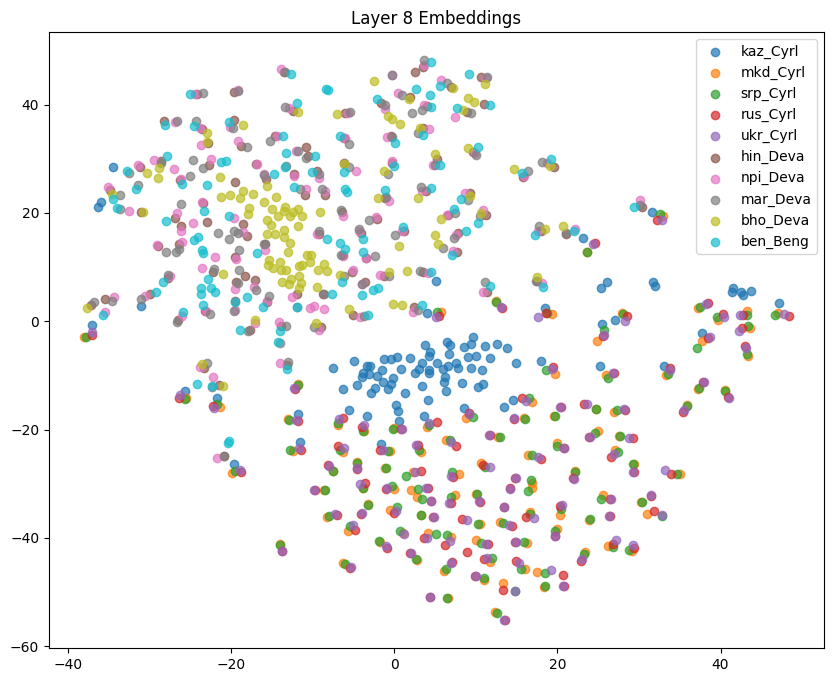

Visualizing embeddings for Layer 9


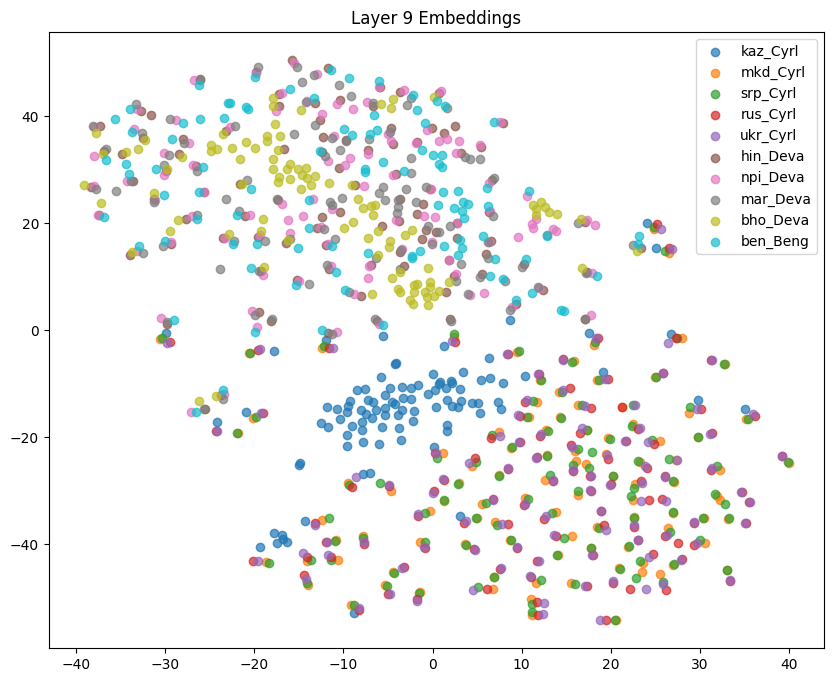

Visualizing embeddings for Layer 10


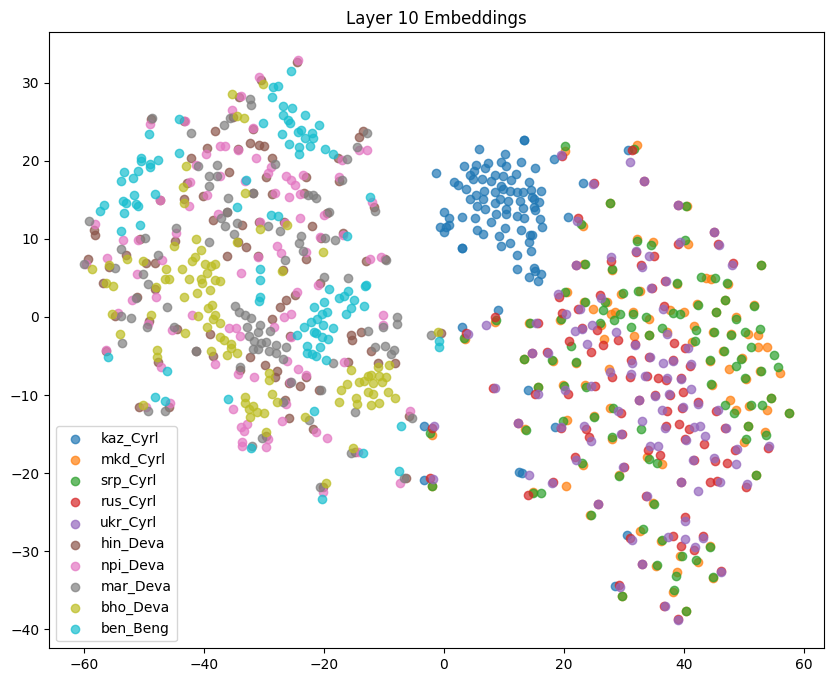

Visualizing embeddings for Layer 11


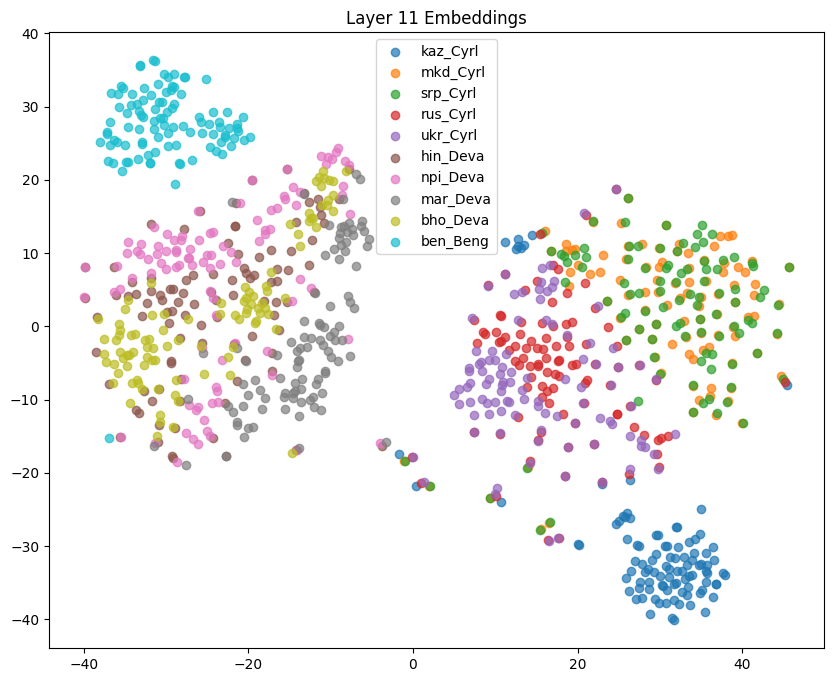

In [9]:
!pip install transformers datasets umap-learn matplotlib

import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.manifold import TSNE
import umap
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.metrics import silhouette_score

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the M-BERT model
MODEL_NAME = "bert-base-multilingual-cased"  # Multilingual BERT
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to(device)
print(f"Model loaded successfully on {device}.")

# Print the number of layers in the M-BERT model
print(f"The M-BERT model has {model.config.num_hidden_layers} layers.")

# Load FLORES200 dataset
dataset = load_dataset("facebook/flores", "all", split="dev")

# Select languages to process
languages = ["kaz_Cyrl","mkd_Cyrl","srp_Cyrl", "rus_Cyrl","ukr_Cyrl", "hin_Deva", "npi_Deva","mar_Deva","bho_Deva","ben_Beng"]
# Extract parallel sentences
parallel_sentences = {}
for lang in languages:
    parallel_sentences[lang] = dataset[f"sentence_{lang}"][:100]  # First 100 sentences

# Function to extract sentence representations with batch processing
def get_representations(model, tokenizer, sentences, layer_indices, batch_size=5):
    """
    Extract embeddings layer-wise for a batch of sentences.
    Args:
        model: HuggingFace model object.
        tokenizer: HuggingFace tokenizer object.
        sentences: List of sentences to process.
        layer_indices: List of layer indices to extract embeddings from.
        batch_size: Number of sentences to process in one batch.
    Returns:
        A dictionary where keys are layer indices and values are 2D arrays (sentences × embedding_dim).
    """
    # Initialize storage for each layer
    layer_representations = {layer: [] for layer in layer_indices}

    for i in range(0, len(sentences), batch_size):
        batch = sentences[i : i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            hidden_states = outputs.hidden_states  # List of tensors (one per layer)

        # Extract mean-pooled embeddings for each layer
        for layer in layer_indices:
            layer_embedding = hidden_states[layer].mean(dim=1)  # Mean-pooling over tokens
            layer_representations[layer].append(layer_embedding.cpu().numpy())

    # Concatenate batches for each layer
    for layer in layer_indices:
        layer_representations[layer] = np.vstack(layer_representations[layer])

    return layer_representations

# Layers to analyze
layers_to_analyze = list(range(model.config.num_hidden_layers))  # Analyze all layers
# Extract representations for all languages
all_representations = {}
for lang in languages:
    print(f"Processing language: {lang}")
    all_representations[lang] = get_representations(
        model, tokenizer, parallel_sentences[lang], layers_to_analyze, batch_size=5
    )

# Function to visualize embeddings
def visualize_multilingual_embeddings(representations, languages, method="TSNE", title="Embedding Visualization"):
    """
    Visualize embeddings for multiple languages.
    Args:
        representations: Dictionary of language embeddings.
        languages: List of languages.
        method: Dimensionality reduction method ('TSNE' or 'UMAP').
        title: Title of the plot.
    """
    combined_repr = []
    labels = []
    for lang in languages:
        combined_repr.append(representations[lang])
        labels.extend([lang] * len(representations[lang]))
    combined_repr = np.vstack(combined_repr)

    # Perform dimensionality reduction
    if method == "TSNE":
        perplexity = min(30, len(combined_repr) - 1)
        reducer = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    elif method == "UMAP":
        reducer = umap.UMAP(n_components=2, random_state=42)
    else:
        raise ValueError("Invalid method. Use 'TSNE' or 'UMAP'.")

    reduced = reducer.fit_transform(combined_repr)

    # Plot
    plt.figure(figsize=(10, 8))
    for lang in languages:
        indices = [i for i, label in enumerate(labels) if label == lang]
        plt.scatter(reduced[indices, 0], reduced[indices, 1], label=lang, alpha=0.7)

    plt.title(title)
    plt.legend()
    plt.show()

# Visualize embeddings for each layer
for layer in layers_to_analyze:
    print(f"Visualizing embeddings for Layer {layer}")
    # Gather embeddings for this layer across all languages
    layer_representations = {lang: all_representations[lang][layer] for lang in languages}
    visualize_multilingual_embeddings(layer_representations, languages, method="TSNE", title=f"Layer {layer} Embeddings")